<a href="https://colab.research.google.com/github/git-hatano/ds_work/blob/main/zero_deep2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ゼロから作るDeepLearning2
https://github.com/oreilly-japan/deep-learning-from-scratch-2

### import / config

In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import time
import os
import collections
import pickle
import sys

In [2]:
#common/config.py
GPU = False

#common/np.py
if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')
else:
    import numpy as np

### [dataset](https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/dataset)

In [3]:
class Spiral:
    def __init__(self) -> None:
        pass

    def load_data(self, seed=1984):
        np.random.seed(seed)
        N = 100  # クラスごとのサンプル数
        DIM = 2  # データの要素数
        CLS_NUM = 3  # クラス数

        x = np.zeros((N*CLS_NUM, DIM))
        t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

        for j in range(CLS_NUM):
            for i in range(N):#N*j, N*(j+1)):
                rate = i / N
                radius = 1.0*rate
                theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

                ix = N*j + i
                x[ix] = np.array([radius*np.sin(theta),
                                radius*np.cos(theta)]).flatten()
                t[ix, j] = 1

        return x, t

PTB コーパス

In [4]:
try:
    import urllib.request
except ImportError:
    raise ImportError('Use Python3!')
import pickle
import numpy as np


url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

# dataset_dir = os.path.dirname(os.path.abspath(__file__))
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/tmp"


def _download(file_name):
    file_path = dataset_dir + '/' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


class Ptb:
    def __init__(self) -> None:
        pass
        
    def load_data(self, data_type='train'):
        '''
            :param data_type: データの種類：'train' or 'test' or 'valid (val)'
            :return:
        '''
        if data_type == 'val': data_type = 'valid'
        save_path = dataset_dir + '/' + save_file[data_type]

        word_to_id, id_to_word = load_vocab()

        if os.path.exists(save_path):
            corpus = np.load(save_path)
            return corpus, word_to_id, id_to_word

        file_name = key_file[data_type]
        file_path = dataset_dir + '/' + file_name
        _download(file_name)

        words = open(file_path).read().replace('\n', '<eos>').strip().split()
        corpus = np.array([word_to_id[w] for w in words])

        np.save(save_path, corpus)
        return corpus, word_to_id, id_to_word

### [functions](https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/functions.py)

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### [layers](https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/layers.py) 

In [6]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size
        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))
        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) * dout / batch_size
        return dx


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        return None

### [time_layers](https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/time_layers.py)

In [7]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx. shape

        self.layers = []
        hs = np.empty((N, T, H), dtype="f")

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H) , dtype="f")
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx. shape

        dxs = np.empty((N, T, D), dtype="f")
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
        
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask

### [optimizer](https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/optimizer.py)

In [8]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

### model

In [9]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 重みとバイアスの初期化
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # レイヤの生成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        # print(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

### [Basemodel](https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/base_model.py)

In [10]:
class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]

###[util](https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/util.py)

In [11]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成
    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    #クエリを取り出す
    if query not in word_to_id:
        print(f"{query} is not found")
        return
    
    print(f"[query] {query}")
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    #コサイン類似度の算出
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    #コサイン類似度の結果から、その値を高い順に出力
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f"{id_to_word[i]}: {similarity[i]}")
        count += 1
        if count >= top:
            return


def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N /(S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M


def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t==0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)


def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換
    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s is not found' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('evaluating perplexity ...')
    corpus_size = len(corpus)
    total_loss = 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)##ここが0になるのがおかしい
    # print(corpus_size-1, batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    # print(total_loss, max_iters)
    ppl = np.exp(total_loss / max_iters)
    return ppl

###[Trainer](https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/trainer.py)

In [12]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()


def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()

##1 ニューラルネットの復習

x (300, 2)
t (300, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


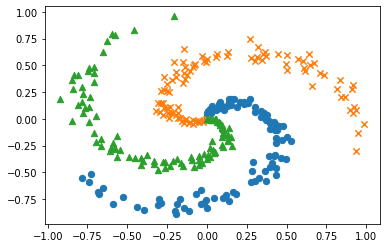

In [13]:
spiral = Spiral()
x, t = spiral.load_data()
print('x', x.shape)  # (300, 2)
print('t', t.shape)  # (300, 3)

# データ点のプロット
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [14]:
#ハイパパラメータ
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

#データの読み込み
spiral = Spiral()
x, t = spiral.load_data()

#model
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
#optimizer
optimizer = SGD(lr=learning_rate)

data_size= len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

# for epoch in range(max_epoch):
#     #データのシャッフル
#     idx = np.random.permutation(data_size)
#     x = x[idx]
#     t = t[idx]
    
#     for iters in range(max_iters):
#         #バッチデータ生成
#         batch_x = x[iters*batch_size : (iters+1)*batch_size]
#         batch_t = t[iters*batch_size : (iters+1)*batch_size]
#         #勾配を求め、パラメータ更新
#         loss = model.forward(batch_x, batch_t)
#         model.backward()
#         optimizer.update(model.params, model.grads)

#         total_loss += loss
#         loss_count += 1

#         if (iters+1) % 10 ==0:
#             avg_loss = total_loss / loss_count
#             print(f"| epoch {epoch+1} | iter {iters+1} / {max_iters} | loss {avg_loss}")
#             loss_list.append(avg_loss)
#             total_loss = 0
#             loss_count = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


In [15]:
# # 学習結果のプロット
# plt.plot(np.arange(len(loss_list)), loss_list, label='train')
# plt.xlabel('iterations (x10)')
# plt.ylabel('loss')
# plt.show()

# # 境界領域のプロット
# h = 0.001
# x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
# y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# X = np.c_[xx.ravel(), yy.ravel()]
# score = model.predict(X)
# predict_cls = np.argmax(score, axis=1)
# Z = predict_cls.reshape(xx.shape)
# plt.contourf(xx, yy, Z)
# plt.axis('off')

# # データ点のプロット
# x, t = spiral.load_data()
# N = 100
# CLS_NUM = 3
# markers = ['o', 'x', '^']
# for i in range(CLS_NUM):
#     plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
# plt.show()

In [16]:
#ハイパパラメータ
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

#データの読み込み
spiral = Spiral()
x, t = spiral.load_data()

#model
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
#optimizer
optimizer = SGD(lr=learning_rate)

# trainer = Trainer(model, optimizer)
# trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)
# trainer.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


##2 自然言語と単語の分散表現

*   シソーラスによる手法
    * シソーラス：類義語辞書で単語の関連性を表現
    * WordNet
*   カウントベースの手法



In [17]:
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace(".", " .")
text

'you say goodbye and i say hello .'

単語にidを割り振る

In [18]:
words = text.split(" ")
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [19]:
word_to_id = {}
id_to_word = {}
for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

コーパス：文章を単語のidで表したもの

In [20]:
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

共起行列：ある単語の近くにある単語を示す行列

In [21]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

#共起行列
C = np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0]
], dtype=np.int32)

print(C[word_to_id["goodbye"]])

[0 1 0 1 0 0 0]


コサイン類似度

In [22]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size= len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id["you"]]
c1 = C[word_to_id["i"]]
cos_similarity(c0, c1)

0.7071067758832467

In [23]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size= len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar("you", word_to_id, id_to_word, C, top=5)

[query] you
goodbye: 0.7071067758832467
i: 0.7071067758832467
hello: 0.7071067758832467
say: 0.0
and: 0.0


相互情報量

In [24]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size= len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


次元削減：特異値分解 (SVD)

In [25]:
U, S, D = np.linalg.svd(W)

print(C[0]) #共起行列
print(W[0]) #PPMI行列
print(U[0]) #SVD
print(U[0, :2]) #SVDで2次元に削減＝先頭の2列を持って来れば良い

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-1.110e-16  3.409e-01 -4.163e-16 -1.205e-01 -1.110e-16 -9.323e-01
 -1.086e-16]
[-1.110e-16  3.409e-01]


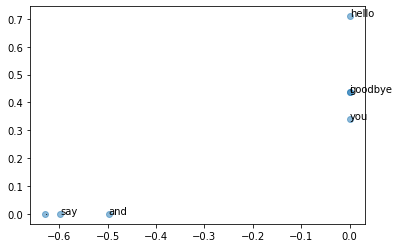

In [26]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

In [27]:
# ptb = Ptb()
# corpus, word_to_id, id_to_word = ptb.load_data("train")

# print('corpus size:', len(corpus))
# print('corpus[:30]:', corpus[:30])
# print()
# print('id_to_word[0]:', id_to_word[0])
# print('id_to_word[1]:', id_to_word[1])
# print('id_to_word[2]:', id_to_word[2])
# print()
# print("word_to_id['car']:", word_to_id['car'])
# print("word_to_id['happy']:", word_to_id['happy'])
# print("word_to_id['lexus']:", word_to_id['lexus'])

In [28]:
# window_size = 2
# wordvec_size = 100

# ptb = Ptb()
# corpus, word_to_id, id_to_word = ptb.load_data("train")
# vocab_size = len(word_to_id)
# print("counting co-occurrence ... ")
# C = create_co_matrix(corpus, vocab_size, window_size)
# print("caluculating PPMI ...")
# W = ppmi(C, verbose=True)

# print("caluculating SVD ... ")
# try:
#     from sklearn.utils.extmath import randomized_svd
#     U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
# except ImportError:
#     U, S, V = np.linalg.svd(W)

# word_vecs = U[:, :wordvec_size]

# querys = ["you", "year", "car", "toyota"]
# for query in querys:
#     most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

##3 word2vec
CBOW

skip-gram

In [29]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.dot(c, W)
h

array([[ 0.339, -1.26 ,  0.576]])

In [30]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
h

array([[ 2.491, -0.446,  1.525]])

In [31]:
# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 純伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
s

array([[ 1.113, -1.843, -1.254,  1.992,  0.988,  0.02 , -0.072]])

CBOW

In [32]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
    
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype("f")
        W_out = 0.01 * np.random.randn(H, V).astype("f")

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 全ての重みと勾配をリストにする
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

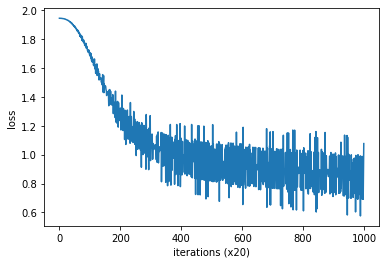

In [33]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)
# print(contexts)
# print(target)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [34]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.161 -1.163 -1.207 -1.204 -1.181]
say [1.097 1.168 1.169 1.165 1.18 ]
goodbye [-0.792 -0.746 -0.719 -0.754 -0.744]
and [1.515 1.134 0.93  0.983 0.922]
i [-0.797 -0.752 -0.725 -0.756 -0.767]
hello [-1.171 -1.153 -1.225 -1.189 -1.173]
. [-0.149  0.798  1.137  1.101  1.154]


##4 word2vec の高速化

In [35]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [36]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            # print(type(word_id))
            # counts[word_id] += 1
            counts[int(word_id)] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [37]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size =2

#cupyだと初期化でエラーが出る
sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
negative_sample

array([[2, 0],
       [1, 4],
       [1, 2]], dtype=int32)

In [38]:
class NegativeSmaplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size+1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size+1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        #正例のforward
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        #負例のforward
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1+i].forward(h, negative_target)
            loss += self.loss_layers[1+i].forward(score, negative_label)

        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        return dh

In [39]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        #重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype("f")
        W_out = 0.01 * np.random.randn(V, H).astype("f")

        #レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSmaplingLoss(W_out, corpus, power=0.75, sample_size=5)

        #全ての重みと勾配を配列にまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        #メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

CBOWの学習と評価

In [40]:
#ハイパパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

#データの読み込み
ptb = Ptb()
corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)

# contexts, target = create_contexts_target(corpus, window_size)
# if GPU:
#     contexts, target = to_gpu(contexts), to_gpu(target)

In [41]:
#モデルなどの生成
# model = CBOW(vocab_size, hidden_size, window_size, corpus)
# optimizer = Adam()
# trainer = Trainer(model, optimizer)

#学習開始
# trainer.fit(contexts, target, max_epoch, batch_size)
# trainer.plot()

In [42]:
#後程利用できるように必要なデータを保存
# word_vecs = model.word_vecs
# if GPU:
#     word_vecs = to_cpu(word_vecs)

# params = {}
# params["word_vecs"] = word_vecs.astype(np.float16)
# params["word_to_id"] = word_to_id
# params["id_to_word"] = id_to_word

# pkl_file = "/content/drive/MyDrive/Colab Notebooks/tmp/cbow_params.pkl"
# with open(pkl_file, "wb") as f:
#     pickle.dump(params, f, -1)

In [43]:
# pkl_file = '/content/drive/MyDrive/Colab Notebooks/tmp/cbow_params.pkl'

# with open(pkl_file, 'rb') as f:
#     params = pickle.load(f)
#     word_vecs = params['word_vecs']
#     word_to_id = params['word_to_id']
#     id_to_word = params['id_to_word']

# # most similar task
# querys = ['you', 'year', 'car', 'toyota']
# for query in querys:
#     most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# # analogy task
# print('-'*50)
# analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
# analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
# analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
# analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

##5 RNN

In [44]:
class SimpleRnnlm:
    def __init__(self, vocab_size,  wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
    
        #重みの初期化
        embed_W = (rn(V, D) / 100).astype("f")
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype("f") 
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype("f")
        rnn_b = np.zeros(H).astype("f")
        affine_W = (rn(H, V) / np.sqrt(H)).astype("f") 
        affine_b = np.zeros(V).astype("f")

        #レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        #全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params 
            self.grads += layer.grads
    
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [45]:
# #ハイパパラメータの設定
# batch_size = 10
# wordvec_size= 100
# hidden_size = 100#RNNの隠れ状態ベクトルの要素数
# time_size = 5     #Truncated BPTTの展開する時間サイズ
# lr = 0.1
# max_epoch = 100

# #データの読み込み
# ptb = Ptb()
# corpus, word_to_id, id_to_word = ptb.load_data("train")
# corpus_size = 1000
# corpus = corpus[:corpus_size]
# vocab_size = int(max(corpus) +1)

# xs = corpus[:-1]#入力
# ts = corpus[1:] #出力：教師ラベル
# data_size = len(xs)
# print(f'corpus size: {corpus_size}, vocabulary size: {vocab_size}')

# #学習時に使用する変数
# max_iters = data_size // (batch_size + time_size)
# time_idx = 0
# total_loss = 0
# loss_count = 0
# ppl_list = []

# #モデルの生成
# model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
# optimizer = SGD(lr)

# #1 ミニバッチの各サンプルの読み込み開始位置を計算
# jump = (corpus_size -1) // batch_size
# offsets = [i * jump for i in range(batch_size)]

# for epoch in range(max_epoch):
#     for iter in range(max_iters):
#         #2 ミニバッチの取得
#         batch_x = np.empty((batch_size, time_size), dtype="i")
#         batch_t = np.empty((batch_size, time_size), dtype="i")
#         for t in range(time_size):
#             for i, offset in enumerate(offsets):
#                 batch_x[i, t] = xs[(offset + time_idx) % data_size]
#                 batch_t[i, t] = ts[(offset + time_idx) % data_size]
#             time_idx += 1
        
#         #勾配を求め、パラメータを更新
#         loss = model.forward(batch_x, batch_t)
#         model.backward()
#         optimizer.update(model.params, model.grads)
#         total_loss += loss
#         loss_count += 1
    
#     #3 epochごとにパープレキシティの評価
#     ppl = np.exp(total_loss / loss_count)
#     print('| epoch %d | perplexity %.2f' % (epoch+1, ppl))
#     ppl_list.append(float(ppl))
#     total_loss, loss_count = 0, 0

In [46]:
# plt.plot(ppl_list)
# plt.xlabel("epochs")
# plt.ylabel("perplexity")
# plt.show()

##6 ゲート付きRNN

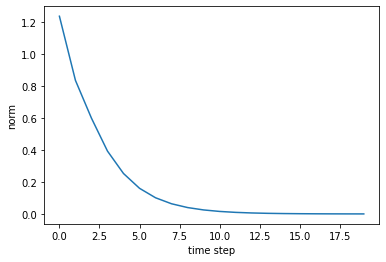

In [47]:
N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
# Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H)*0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

plt.plot(norm_list)
plt.xlabel("time step")
plt.ylabel("norm")
plt.show()

勾配爆発への対策：勾配クリッピング

In [48]:
dW1 = np.random.rand(3, 3)*10
dW2 = np.random.rand(3, 3)*10
grads = [dW1, dW2]
max_norm = 5.0
print("before")
print(dW1)

clip_grads(grads, max_norm)
print("after")
print(dW1)

before
[[6.491 2.785 6.763]
 [5.909 0.24  5.589]
 [2.593 4.151 2.835]]
after
[[1.495 0.641 1.557]
 [1.361 0.055 1.287]
 [0.597 0.956 0.653]]


勾配消失への対策：セル、ouputゲート、forgetゲート、inputゲートの導入

In [49]:
class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

In [50]:
# #ハイパパラメータの生成
# batch_size = 20
# wordvec_size = 100
# hidden_size = 100
# time_size = 35
# lr = 20.0
# max_epoch = 4
# max_grad = 0.25

# #学習データの読み込み
# ptb = Ptb()
# corpus, word_to_id, id_to_word = ptb.load_data("train")
# corpus_test, _ , _ = ptb.load_data("test")
# vocab_size = len(word_to_id)
# xs = corpus[:-1]#入力
# ts = corpus[1:] #出力：教師ラベル

# #モデルの生成
# model = Rnnlm(vocab_size, wordvec_size, hidden_size)
# optimizer = SGD(lr)
# trainer = RnnlmTrainer(model, optimizer)

# #勾配クリッピングを適用して学習
# trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
# trainer.plot(ylim=(0, 500))

# #テストデータで評価
# model.reset_state()
# ppl_test = eval_perplexity(model, corpus_test)
# print('test perplexity: ', ppl_test) 

# #パラメータの保存
# model.save_params()

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 8[s] | perplexity 2965.95
| epoch 1 |  iter 41 / 1327 | time 18[s] | perplexity 1249.61
| epoch 1 |  iter 61 / 1327 | time 25[s] | perplexity 961.73
| epoch 1 |  iter 81 / 1327 | time 30[s] | perplexity 808.38
| epoch 1 |  iter 101 / 1327 | time 35[s] | perplexity 655.81
| epoch 1 |  iter 121 / 1327 | time 41[s] | perplexity 652.26
| epoch 1 |  iter 141 / 1327 | time 46[s] | perplexity 594.54
| epoch 1 |  iter 161 / 1327 | time 50[s] | perplexity 577.65
| epoch 1 |  iter 181 / 1327 | time 55[s] | perplexity 597.14
| epoch 1 |  iter 201 / 1327 | time 60[s] | perplexity 498.29
| epoch 1 |  iter 221 / 1327 | time 65[s] | perplexity 489.40
| epoch 1 |  iter 241 / 1327 | time 70[s] | perplexity 452.50
| epoch 1 |  iter 261 / 1327 | time 74[s] | perplexity 471.56
| epoch 1 |  iter 281 / 1327 | time 79[s] | perplexity 446.90
| epoch 1 |  iter 301 / 1327 | time 84[s] | perplexity 400.39
| epoch 1 |  

KeyboardInterrupt: ignored

In [55]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype("f")
        lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype("f")
        lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype("f")
        lstm_b1 = np.zeros(4*H).astype("f")
        lstm_Wx2 = (rn(H, 4*H) / np.sqrt(H)).astype("f")
        lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype("f")
        lstm_b2 = np.zeros(4*H).astype("f")
        affine_b = np.zeros(V).astype("f")

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)#重み共有
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
# # ハイパーパラメータの設定
# batch_size = 20
# wordvec_size = 650 
# hidden_size = 650
# time_size = 35
# lr = 20.0 
# max_epoch = 40 
# max_grad = 0.25 
# dropout = 0.5 

# # 学習データの読み込み 
# corpus, word_to_id, id_to_word = ptb.load_data('train') 
# corpus_val, _, _ = ptb.load_data('val') 
# corpus_test, _, _ = ptb.load_data('test') 

# vocab_size = len(word_to_id) 
# xs = corpus[:-1] 
# ts = corpus[1:] 

# model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout) 
# optimizer = SGD(lr) 
# trainer = RnnlmTrainer(model, optimizer)

# best_ppl = float("inf")
# for epoch in range(max_epoch):
#     trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
#     model.reset_state()
#     ppl = eval_perplexity(model, corpus_val)
#     print('valid perplexity: ', ppl)

#     if best_ppl > ppl:
#         best_ppl = ppl
#         model.save_params("/content/drive/MyDrive/Colab Notebooks/tmp/Rnnlm.pkl")
#     else:
#         lr /= 4.0
#         optimizer.lr = lr

#     model.reset_state()
#     print("-" *50)

##7 RNNによる文章生成

In [51]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        return word_ids

In [53]:
ptb = Ptb()
corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params("/content/drive/MyDrive/Colab Notebooks/tmp/Rnnlm.pkl")

#start文字とskip文字の設定
start_word = "you"
start_id = word_to_id[start_word]
skip_words = ["N", "<unk>", "$"]
skip_ids = [word_to_id[w] for w in skip_words]

#文章生成
word_ids = model.generate(start_id, skip_ids)
txt = " ".join([id_to_word[i] for i in word_ids])
txt = txt.replace(" <eos>", ".\n")
print(txt)

you caution.
 it was the mess of an portrayal of employees with the planet.
 the rothschilds always be this told the maker of negative accompanied parents has n't taken yet full-time projects.
 but the stock would be wrap and loss over the catalyst was.
 the capital brand wall has a standard of else this to serve.
 in that market we own your technique could identify people or what 's no gloomy tasks could be able to sell a way between sure of double the basis of his partnership 's stake.
 no work refused to


In [60]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        return word_ids

In [61]:
ptb = Ptb()
corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()
model.load_params("/content/drive/MyDrive/Colab Notebooks/tmp/BetterRnnlm.pkl")

#start文字とskip文字の設定
start_word = "you"
start_id = word_to_id[start_word]
skip_words = ["N", "<unk>", "$"]
skip_ids = [word_to_id[w] for w in skip_words]

#文章生成
word_ids = model.generate(start_id, skip_ids)
txt = " ".join([id_to_word[i] for i in word_ids])
txt = txt.replace(" <eos>", ".\n")
print(txt)

you wish to be making this move.
 the plan expired in july is to office an appeal from holiday further than thursday 's agreement.
 still even the company faces loan the outcome of being filed in march.
 a halt on the stock exchange 's high sank greatly by the uncertainty in what do you perceived any sample of program trading.
 enemies in the market were only a very good indicator for companies.
 as the relationship limits the dollar sell-off a little more and ride confusion about the s&p futures.
 you did very even if
